# Microsoft Movie Studios

**Author:** Team 5
***

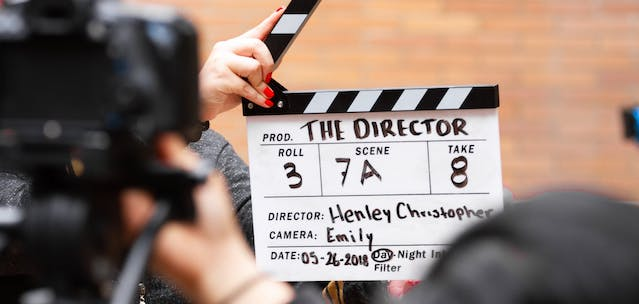

## Overview

This project analyzes the creative needs of <a href="http://www.microsoft.com">Microsoft</a>, an expansive computer software and hardware manufacturer.  Microsoft has made a strategic decision to create a new movie studio. Analysis of popular film genres and financial data from the Internet Movie Database <a href="http://www.imdb.com/interfaces/">(IMDb)</a> clearly shows that top earning films are centered around a few film types.  Additionaly, one studio group stands out as the creative leader in these genres.  Microsoft can use this analysis to set visioning, hiring practices, property acqusition and advertising for their initial resource allocation.

## Business Problem

Microsoft has decided to expand its considerable expertise into the area of producing feature films.  As a new entry into this competitive and creative arena, they need an analysis of the types of films that are doing best at the box office.  Using data from the Internet Movie Database <a href="http://www.imdb.com/interfaces/">(IMDb)</a>, Box Office Mojo <a href="http://www.boxofficemojo.com/">(BOM)</a>, and The Numbers <a href="http://www.the-numbers.com/">(TN)</a>, we will describe patterns from succesful production houses. By analyzing and comparing film generes, gross receipts, year to year consistency and studio success, this analysis will aid Microsoft in clarifying the vision, culture and resource management for their new subsidiary.

## Data Understanding

The data sets we are using are from the Internet Movie Database (IMDb) and a subsiderary company, Box Office Mojo (BOM). Both are owned by Amazon, and represent the largest repository of film data available. These files have information about movie genres, gross receipts domestically and abroad, plus basic things like titles, release year, studios, runtime, etc. We will also be using a dataset from The Numbers (TN), which contains additional information like production budgets (allowing us to calculate net profits and ROI). There was an additional dataset that we examined,from Rotten Tomatoes (RT), but we determined it to not be able to yield any additional information within our areas of focus, so we did not ultimately make use of it.

In [1]:
# Import relevant modules

import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(color_codes=True)

In [2]:
!ls data

bom.movie_gross.csv  rt.reviews.tsv    title.principals.csv
df_all3.csv	     title.akas.csv    title.ratings.csv
name.basics.csv      title.basics.csv  tmdb.movies.csv
rt.movie_info.tsv    title.crew.csv    tn.movie_budgets.csv


Here we'll import all of the CSVs as pandas dataframes. The comments above each import list the most important columns in each dataset (though not necessarily by actual column name, in order to be able to cross-reference them to the other datasets).

In [3]:
# Title, Studio, Domestic Gross, Foreign Gross, Year
movie_gross_df = pd.read_csv('data/bom.movie_gross.csv')

# Name variable (nconst), Name of Crew/Principal, Primary Profession, Known for Titles (tconst)
people_info_df = pd.read_csv('data/name.basics.csv')

# ID, Rating, Genre, Director, Writer, Theater Date, Box Office, Runtime, Studio
rt_movie_info_df = pd.read_csv('data/rt.movie_info.tsv', delimiter='\t')

# ID, Rating, Fresh, Top Critic
rt_movie_reviews_df = pd.read_csv('data/rt.reviews.tsv', delimiter='\t', encoding='latin1')

# Title ID, Title, Region, Language
title_akas_df = pd.read_csv('data/title.akas.csv')

# Title ID (tconst), Primary Title, Original Title, Year, Runtime, Genres
title_basics_df = pd.read_csv('data/title.basics.csv')

# Title ID (tconst), Directors (nconst), Writers (nconst)
title_crew_df = pd.read_csv('data/title.crew.csv')

# Title ID (tconst), People (nconst), Category (primary profession)
title_principals_df = pd.read_csv('data/title.principals.csv')

# Titled ID (tconst), Rating, Num Votes
title_ratings_df = pd.read_csv('data/title.ratings.csv')

# Genre, Language, Original Title, Popularity, Date, Title, Average Rating, Num of Ratings
tmdb_movies_df = pd.read_csv('data/tmdb.movies.csv')

# Release Date, Title, Budget, Domestic Gross, Worldwide Gross
movie_budgets_df = pd.read_csv('data/tn.movie_budgets.csv')

Here, we'll clean up one of the key datasets, dropping NaNs, and restricting the entries to those whose release years are from 2008 - 2018. We'll also calculate both profits and ROI over the time period to see if there are any interesting trends in the data.

In [4]:
movie_budgets_clean = movie_budgets_df.dropna(subset=['production_budget', 'domestic_gross', 'worldwide_gross'], how='any')

movie_budgets_numeric = movie_budgets_clean
movie_budgets_numeric[movie_budgets_numeric.columns[3:]] = movie_budgets_numeric[movie_budgets_numeric.columns[3:]].apply(lambda x: x.str[1:].str.split(',').str.join('')).astype(np.int64)

roi_df = movie_budgets_numeric[movie_budgets_numeric.domestic_gross !=0]
roi_df = roi_df[roi_df.worldwide_gross !=0]

roi_df['roi'] = (roi_df['worldwide_gross'] - roi_df['production_budget']) / roi_df['production_budget'] * 100

roi_recent = roi_df
roi_recent['release_date'] = pd.to_datetime(roi_recent['release_date'], format='%b %d, %Y')
roi_recent = roi_recent[roi_recent['release_date'] >= pd.Timestamp(2008, 1, 1, 12)]

profits_roi_df = roi_df
profits_roi_df['profit'] = profits_roi_df['worldwide_gross'] - profits_roi_df['production_budget']

profits_recent = profits_roi_df
profits_recent = profits_recent[profits_recent['release_date'] >= pd.Timestamp(2008, 1, 1, 12)]

In [5]:
# Add columns for day of year (numeric, 1-365) and month (numeric, 1-2)
# Hide the output as python dislikes this operation without using .loc.
profits_recent['day_of_year'] = profits_recent['release_date'].dt.dayofyear
profits_recent['month'] = profits_recent['release_date'].dt.month

<ipython-input-5-966cbd7c3af8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profits_recent['day_of_year'] = profits_recent['release_date'].dt.dayofyear
<ipython-input-5-966cbd7c3af8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profits_recent['month'] = profits_recent['release_date'].dt.month


In [6]:
profits_recent.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,roi,profit,day_of_year,month
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,553.257713,2351345279,352,12
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,154.667286,635063875,140,5
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,-57.210757,-200237650,158,6
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,324.384139,1072413963,121,5
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,315.369636,999721747,349,12


## First steps: Determine what sorts of movies correlate to higher profits

Here we'll do a few graphs of ROI and profits against production budget, as well as calculating their correlations, just to get a feel for the data and to get a vague picture of how much production budgets matter.

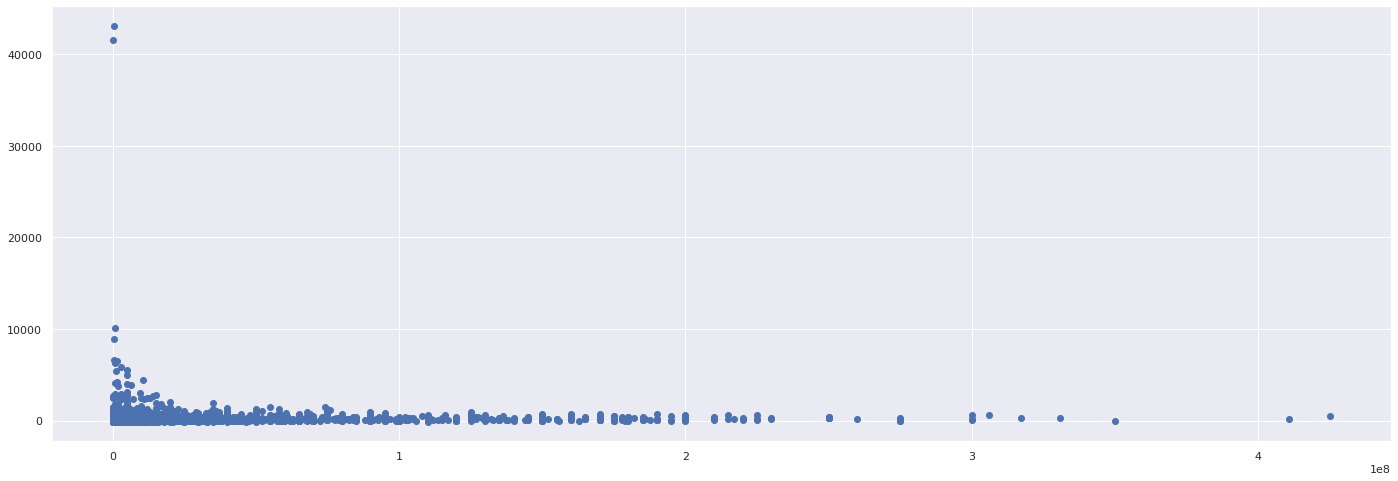

In [7]:
sns.set(rc={"figure.figsize":(24, 8)})

fig, ax = plt.subplots()

ax.scatter(roi_recent['production_budget'], roi_recent['roi']);

That's a tad difficult to see what's going on. We'll take out the outliers.

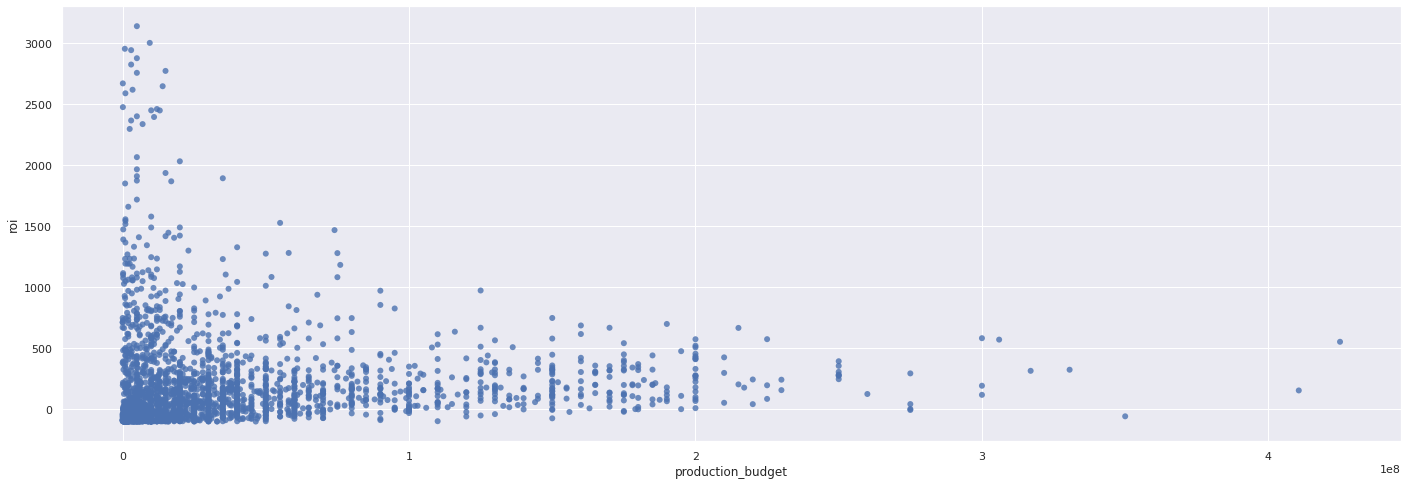

In [8]:
roi_recent_no_outliers = roi_recent

roi_recent_no_outliers = roi_recent_no_outliers[roi_recent['roi'] < 3500]

sns.scatterplot(x='production_budget', y='roi', data=roi_recent_no_outliers, edgecolor='none', alpha=.8);

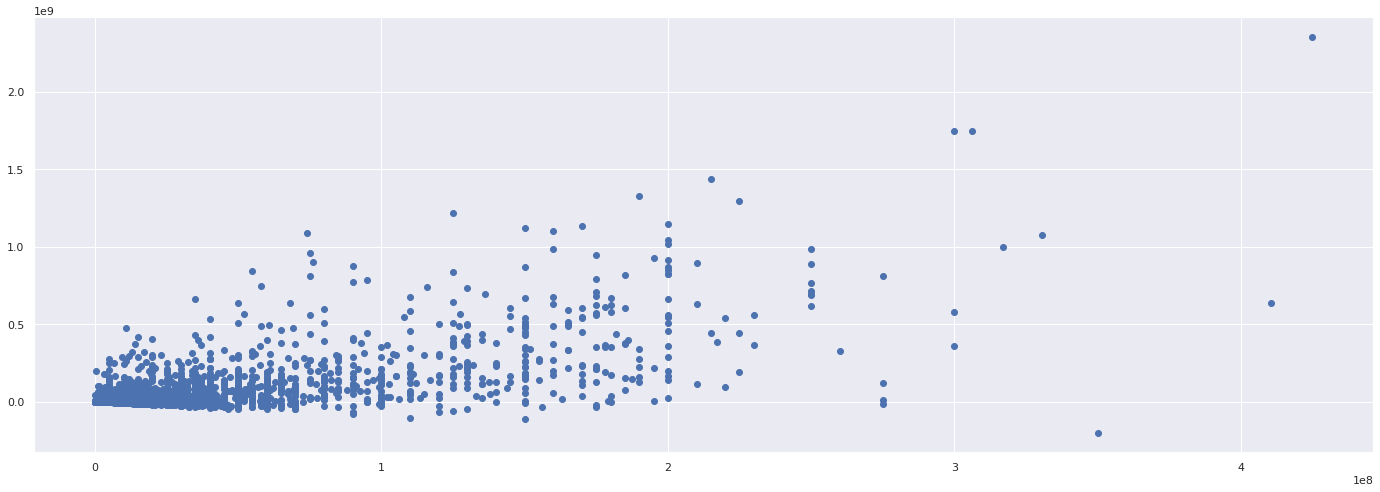

In [9]:
fig, ax = plt.subplots()

ax.scatter(profits_recent['production_budget'], profits_recent['profit']);

In [10]:
print('The correlation between production budget and profit is {}.'.format(round(np.corrcoef(profits_recent['production_budget'], profits_recent['profit'])[0][1], 3)))
print('The correlation between production budget and ROI is {}.'.format(round(np.corrcoef(profits_recent['production_budget'], profits_recent['roi'])[0][1], 3)))

The correlation between production budget and profit is 0.672.
The correlation between production budget and ROI is -0.043.


So it looks like there's a loose correlation between production budget and profit but nearly no correlation between production budget and ROI. Given that, it may be useful to either break movies down into smaller categories (e.g. by budget, by genre, etc.) and/or come up with an alternative metric of profitability. To that end, instead of measuring by pure profit, let's measure by how often certain types of movies generate a profit, and we will indeed apply this metric to smaller categories of movies to get a more gran.

### Next: Break movies down into smaller categories, first by budget

We'll define low budgets as anything less than \\$10m, middle budgets from there to \\$100m, and big budgets as anything over \\$100m. 

In [11]:
low_budget = profits_recent[profits_recent['production_budget'] < 10000000]
middle_budget = profits_recent[(profits_recent['production_budget'] >= 10000000) & (profits_recent['production_budget'] < 100000000)]
big_budget = profits_recent[profits_recent['production_budget'] >= 100000000]

And now we'll calculate the percentage of movies in each category that make at least some net profit.

In [12]:
low_budget_profitability = round(low_budget[low_budget['profit'] > 0]['id'].count() / low_budget['id'].count() * 100, 2)
middle_budget_profitability = round(middle_budget[middle_budget['profit'] > 0]['id'].count() / middle_budget['id'].count() * 100, 2)
big_budget_profitability = round(big_budget[big_budget['profit'] > 0]['id'].count() / big_budget['id'].count() * 100, 2)

print('{}% of low budget movies are profitable.'.format(low_budget_profitability))
print('{}% of middle budget movies are profitable.'.format(middle_budget_profitability))
print('{}% of big budget movies are profitable.'.format(big_budget_profitability))

56.21% of low budget movies are profitable.
73.94% of middle budget movies are profitable.
93.29% of big budget movies are profitable.


It looks like the higher the budget, the more likely a film is to generate a net profit. Let's next look at the distributions of profits across each of these categories in order to determine the spread and skew.

In [13]:
sns.set(rc={"figure.figsize":(12, 4)});

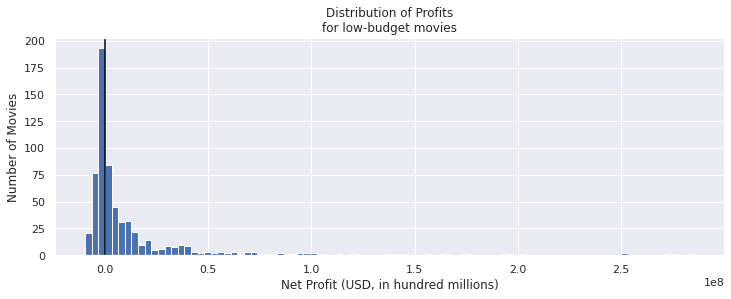

In [14]:
fig, ax = plt.subplots()

ax.hist(low_budget['profit'], bins='auto')
#ax.set_ylim([0, 100])
ax.axvline(x=0, color='black')
ax.set_xlabel('Net Profit (USD, in hundred millions)')
ax.set_ylabel('Number of Movies')
ax.set_title('Distribution of Profits\nfor low-budget movies')
plt.savefig('Images/lowbudgetdistribution.png', dpi=300, bbox_inches = "tight");

In [15]:
print('{}% of low budget movies are profitable.'.format(low_budget_profitability))

56.21% of low budget movies are profitable.


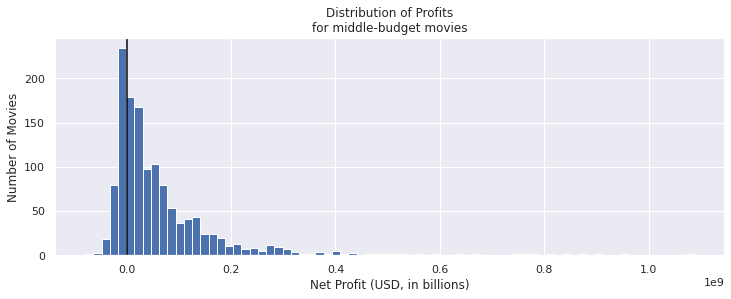

In [16]:
fig, ax = plt.subplots()

ax.hist(middle_budget['profit'], bins='auto')
ax.axvline(x=0, color='black')
ax.set_xlabel('Net Profit (USD, in billions)')
ax.set_ylabel('Number of Movies')
ax.set_title('Distribution of Profits\nfor middle-budget movies');

In [17]:
print('{}% of middle budget movies are profitable.'.format(middle_budget_profitability))

73.94% of middle budget movies are profitable.


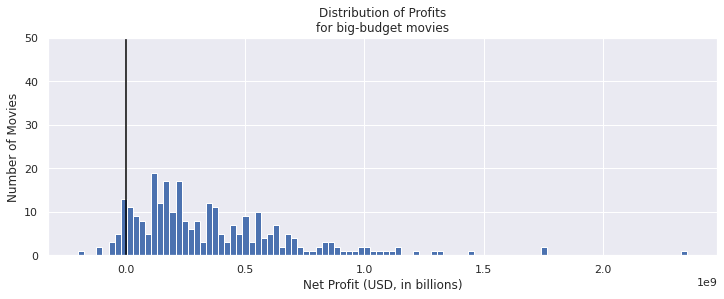

In [18]:
fig, ax = plt.subplots()

ax.hist(big_budget['profit'], bins=100)
ax.set_ylim([0, 50])
ax.axvline(x=0, color='black')
ax.set_xlabel('Net Profit (USD, in billions)')
ax.set_ylabel('Number of Movies')
ax.set_title('Distribution of Profits\nfor big-budget movies')
plt.savefig('Images/bigbudgetdistribution.png', dpi=300, bbox_inches = "tight");

In [19]:
print('{}% of big budget movies are profitable.'.format(big_budget_profitability))

93.29% of big budget movies are profitable.


So not only do big-budget movies look safer in terms of frequency of profit, they appear to have a higher relative median profit as well. 

In [20]:
print('The median profit of low-budget movies is {}.'.format(int(low_budget['profit'].median())))
print('The median profit of middle-budget movies is {}.'.format(int(middle_budget['profit'].median())))
print('The median profit of big-budget movies is {}.'.format(int(big_budget['profit'].median())))

The median profit of low-budget movies is 540754.
The median profit of middle-budget movies is 28555085.
The median profit of big-budget movies is 263186950.


And indeed that does seem to be the case. Given that, we will be recommending to Microsoft that they focus the bulk of their energies and resources on bigger budget films, as they are both significantly more profitable, relatively speaking, AND significatly more often profitable in the first place. We won't recommend against making other sorts of movies as well, but it appears that to succeed in low-budget movies requires bulk. The safe and steady money looks to be higher up.

## New Question: What does it look like if we run the same sorts of analyses across different genres instead of budget?

We'll start off by rangling the datasets so that we can compare films of different genres and their profits. This will involve another round of data prep and cleaning.

In [21]:
# Now that we have a better general sense of the data, we'll rename some of the dataframes, just so they're easier to work with
df1 = title_basics_df
df2 = title_ratings_df
df3 = movie_gross_df
df4 = movie_budgets_df

df1.shape, df2.shape, df3.shape, df3.shape

((146144, 6), (73856, 3), (3387, 5), (3387, 5))

### DF1

This data set contains titles, premiere year, runtime and film genres, along with an index.

In [22]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [23]:
df1['genres'].value_counts()

Documentary                    32185
Drama                          21486
Comedy                          9177
Horror                          4372
Comedy,Drama                    3519
                               ...  
Family,Fantasy,Mystery             1
Comedy,History,Sport               1
Adventure,Biography,Western        1
Animation,Sci-Fi,Sport             1
Horror,Talk-Show                   1
Name: genres, Length: 1085, dtype: int64

In [24]:
len(df1['tconst'].unique()) # the output matches the number of entries for 'tconst'.  The values are unique

146144

### DF2

This data set contains fan rating and voting information along with an index.

In [25]:
df2.head()

,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [26]:
df2['averagerating'].value_counts(bins=10)

(6.4, 7.3]     19088
(5.5, 6.4]     16563
(7.3, 8.2]     12473
(4.6, 5.5]      9861
(3.7, 4.6]      5452
(8.2, 9.1]      5354
(2.8, 3.7]      2819
(1.9, 2.8]      1112
(9.1, 10.0]      715
(0.99, 1.9]      419
Name: averagerating, dtype: int64

In [27]:
df2['numvotes'].value_counts(bins=12)

(-1836.062, 153426.75]     73443
(153426.75, 306848.5]        243
(306848.5, 460270.25]         91
(460270.25, 613692.0]         45
(613692.0, 767113.75]         22
(767113.75, 920535.5]          4
(920535.5, 1073957.25]         3
(1073957.25, 1227379.0]        2
(1687644.25, 1841066.0]        1
(1380800.75, 1534222.5]        1
(1227379.0, 1380800.75]        1
(1534222.5, 1687644.25]        0
Name: numvotes, dtype: int64

In [28]:
len(df2['tconst'].unique()) # the output matches the number of entries for 'tconst'.  The values are unique

73856

### DF3

This data set contains titles, production studio, year of release from 2010 - 2018, and domestic and foreign gross receipts.

In [29]:
df3.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [30]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [31]:
# Updating column names for readability in graphs
df3['studio'].replace({"WB (NL)": "WB"}, inplace=True)
df3['studio'].replace({"WB": "Warner Bros", 'BV': 'Disney', 'Uni.': "Universal", 'P/DW': 'DreamWorks', 'Par.': 'Paramount'}, inplace=True)
df3['studio'].value_counts()

Warner Bros    185
IFC            166
Universal      147
Magn.          136
Fox            136
              ... 
Abk.             1
Proud            1
MSF              1
AaF              1
CAVU             1
Name: studio, Length: 256, dtype: int64

### DF4

In [32]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


### Data Preparation

Each dataset contains pieces of information vital to making an analysis.  Our process is:
    
    Doing a left merge on df1 and df2 by 'tconst' to create the dataset df_imbd
    Doing a right merge on df_bom and df4 on the 'title' column
    Doing an right merge on df_imbd and df_money by 'title' to create a complete dataset.
    Cleaning up the data:
        1.  Delete the 'original_title', 'start_year' and the 'runtime_minutes" columns
        2.  Change the foreign_gross column to float64 Dtype from object Dtype
        3.  Add a column that is the sum of 'domestic_gross' and 'foreign_gross' entitled 'worldwide_gross'
        4.  Delete duplicates in the title column

### Merging datasets

In [33]:
df_imdb = df1.merge(df2, on="tconst", how = 'left')
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146144 entries, 0 to 146143
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
 6   averagerating    73856 non-null   float64
 7   numvotes         73856 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 10.0+ MB


In [34]:
df_imdb['primary_title'].isin(df3['title']).value_counts()

False    142780
True       3364
Name: primary_title, dtype: int64

First, we'll rename the 'primary_title' column in 'df_imdb' to 'title'

In [35]:
df_imdb.rename(columns={'primary_title': 'title'}, inplace=True)

Now we'll prepare the the df3 and df4 files for merging, which contains financial and studio data.

In [36]:
df_bom = df3.drop(['domestic_gross','foreign_gross'], axis = 1)

In [37]:
df4.rename(columns={'movie': 'title'}, inplace=True)

In [38]:
df_money = df_bom.merge(df4, on = 'title', how = 'right')
df_money

,title,studio,year,id,release_date,production_budget,domestic_gross,worldwide_gross
0,Avatar,NaN,NaN,1,"Dec 18, 2009","$425,000,000","$760,507,625","$2,776,345,279"
1,Pirates of the Caribbean: On Stranger Tides,Disney,2011.0,2,"May 20, 2011","$410,600,000","$241,063,875","$1,045,663,875"
2,Dark Phoenix,NaN,NaN,3,"Jun 7, 2019","$350,000,000","$42,762,350","$149,762,350"
3,Avengers: Age of Ultron,Disney,2015.0,4,"May 1, 2015","$330,600,000","$459,005,868","$1,403,013,963"
4,Star Wars Ep. VIII: The Last Jedi,NaN,NaN,5,"Dec 15, 2017","$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...,...,...
5777,Red 11,NaN,NaN,78,"Dec 31, 2018","$7,000",$0,$0
5778,Following,NaN,NaN,79,"Apr 2, 1999","$6,000","$48,482","$240,495"
5779,Return to the Land of Wonders,NaN,NaN,80,"Jul 13, 2005","$5,000","$1,338","$1,338"
5780,A Plague So Pleasant,NaN,NaN,81,"Sep 29, 2015","$1,400",$0,$0


This merge did not completely give the results we wanted, but was the best of the options available.  It resulted in having to hard code some data to complete our top grossing movies list.

Now we'll merge the IMBd data with the BOM data, which has all the gross receipts details.  The commonality between these files is the titles; of the 3387 rows in the BOM data file, 3025 of them have matching data in the 'title' column with the 'primary_title' column in the IMDb file.  

In [39]:
df_all3 = df_imdb.merge(df_money, on="title", how = 'right')

In [40]:
df_all3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7221 entries, 0 to 7220
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tconst             3815 non-null   object 
 1   title              7221 non-null   object 
 2   original_title     3814 non-null   object 
 3   start_year         3815 non-null   float64
 4   runtime_minutes    3328 non-null   float64
 5   genres             3743 non-null   object 
 6   averagerating      2875 non-null   float64
 7   numvotes           2875 non-null   float64
 8   studio             1681 non-null   object 
 9   year               1682 non-null   float64
 10  id                 7221 non-null   int64  
 11  release_date       7221 non-null   object 
 12  production_budget  7221 non-null   object 
 13  domestic_gross     7221 non-null   object 
 14  worldwide_gross    7221 non-null   object 
dtypes: float64(5), int64(1), object(9)
memory usage: 902.6+ KB


### Data Cleaning

In [41]:
# remove all but numbers in  the gross earnings columns
df_all3['domestic_gross'] = df_all3['domestic_gross'].apply(str).str.replace(r"[a-zA-Z$,]",'')
df_all3['worldwide_gross'] = df_all3['worldwide_gross'].apply(str).str.replace(r"[a-zA-Z$,]",'')

In [42]:
# convert gross earnings columns to numeric
df_all3['domestic_gross'] = pd.to_numeric(df_all3['domestic_gross'], errors = 'coerce')
df_all3['worldwide_gross'] = pd.to_numeric(df_all3['worldwide_gross'], errors = 'coerce')

In [43]:
df_all3 = df_all3.drop_duplicates(subset=['title'])

In [44]:
df_all3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5698 entries, 0 to 7220
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tconst             2312 non-null   object 
 1   title              5698 non-null   object 
 2   original_title     2312 non-null   object 
 3   start_year         2312 non-null   float64
 4   runtime_minutes    2138 non-null   float64
 5   genres             2287 non-null   object 
 6   averagerating      2033 non-null   float64
 7   numvotes           2033 non-null   float64
 8   studio             1237 non-null   object 
 9   year               1238 non-null   float64
 10  id                 5698 non-null   int64  
 11  release_date       5698 non-null   object 
 12  production_budget  5698 non-null   object 
 13  domestic_gross     5698 non-null   int64  
 14  worldwide_gross    5698 non-null   int64  
dtypes: float64(5), int64(3), object(7)
memory usage: 712.2+ KB


### Next: Sorting out each genre

We'll create separate dataframes for each genre for easier graphing and analysis.

In [45]:
#Hard coding to add missing values

df_replace_na = df_all3.nlargest(25,'worldwide_gross')
df_replace_na_select = df_replace_na[['title', 'genres', 'year', 'studio', 'production_budget', 'worldwide_gross', 'domestic_gross']]

# Avatar
df_replace_na_select.at[df_replace_na_select.index[0], 'genres'] = 'Action,Adventure,Sci-Fi'
df_replace_na_select.at[df_replace_na_select.index[0], 'year'] = '2009'
df_replace_na_select.at[df_replace_na_select.index[0], 'studio'] = '20th Century Fox'

# Titanic
df_replace_na_select.at[df_replace_na_select.index[1], 'year'] = '1997'
df_replace_na_select.at[df_replace_na_select.index[1], 'studio'] = 'Paramount'

# Star Wars VII
df_replace_na_select.at[df_replace_na_select.index[2], 'genres'] = 'Action,Adventure,Sci-Fi'
df_replace_na_select.at[df_replace_na_select.index[2], 'year'] = '2015'
df_replace_na_select.at[df_replace_na_select.index[2], 'studio'] = 'Disney'

# The Avengers
df_replace_na_select.at[df_replace_na_select.index[6], 'year'] = '2012'
df_replace_na_select.at[df_replace_na_select.index[6], 'studio'] = 'Disney'

# Harry Potter - Deathly Hallows 2
df_replace_na_select.at[df_replace_na_select.index[9], 'genres'] = 'Action,Adventure,Sci-Fi'
df_replace_na_select.at[df_replace_na_select.index[9], 'year'] = '2011'
df_replace_na_select.at[df_replace_na_select.index[9], 'studio'] = 'Warner Bros'

# Star Wars VIII
df_replace_na_select.at[df_replace_na_select.index[10], 'genres'] = 'Action,Adventure,Sci-Fi'
df_replace_na_select.at[df_replace_na_select.index[10], 'year'] = '2017'
df_replace_na_select.at[df_replace_na_select.index[10], 'studio'] = 'Disney'

# Beauty and the Beast
df_replace_na_select.at[df_replace_na_select.index[13], 'year'] = '2017'
df_replace_na_select.at[df_replace_na_select.index[13], 'studio'] = 'Disney'

In [46]:
df_replace_na_select = df_replace_na_select[df_replace_na_select['year'] >= 2008]

In [47]:
# pd.set_option("display.max_rows", None)
df_genres = df_all3.dropna(subset = ['genres'])

df_genres.at[df_replace_na_select.index[0], 'genres'] = 'Action,Adventure,Sci-Fi'
df_genres.at[df_replace_na_select.index[0], 'year'] = '2009'
df_genres.at[df_replace_na_select.index[0], 'studio'] = '20th Century Fox'
df_genres.at[df_replace_na_select.index[2], 'genres'] = 'Action,Adventure,Sci-Fi'
df_genres.at[df_replace_na_select.index[2], 'year'] = '2015'
df_genres.at[df_replace_na_select.index[2], 'studio'] = 'Disney'
df_genres.at[df_replace_na_select.index[9], 'genres'] = 'Action,Adventure,Sci-Fi'
df_genres.at[df_replace_na_select.index[9], 'year'] = '2011'
df_genres.at[df_replace_na_select.index[9], 'studio'] = 'Warner Bros'
df_genres.at[df_replace_na_select.index[10], 'genres'] = 'Action,Adventure,Sci-Fi'
df_genres.at[df_replace_na_select.index[10], 'year'] = '2017'
df_genres.at[df_replace_na_select.index[10], 'studio'] = 'Disney'

df_genres['domestic_gross'] = df_genres['domestic_gross'].apply(str).str.replace(r"[a-zA-Z$,]",'')
df_genres['worldwide_gross'] = df_genres['worldwide_gross'].apply(str).str.replace(r"[a-zA-Z$,]",'')
df_genres['production_budget'] = df_genres['production_budget'].apply(str).str.replace(r"[a-zA-Z$,]",'')
df_genres['worldwide_gross'] = pd.to_numeric(df_genres['worldwide_gross'], errors = 'coerce')
df_genres['production_budget'] = pd.to_numeric(df_genres['production_budget'], errors = 'coerce')
df_genres['profit'] = df_genres['worldwide_gross'] - df_genres['production_budget']
df_genres['ROI'] = df_genres['profit'] / df_genres['production_budget'] * 100
df_genres['release_date'] = pd.to_datetime(df_genres['release_date'], format='%b %d, %Y')
df_genres['month'] = df_genres['release_date'].dt.month

df_horror = df_genres.loc[df_genres['genres'].str.contains('Horror')]
df_adventure = df_genres.loc[df_genres['genres'].str.contains('Adventure')]
df_action = df_genres.loc[df_genres['genres'].str.contains('Action')]
df_scifi = df_genres.loc[df_genres['genres'].str.contains('Sci-Fi')]
df_comedy = df_genres.loc[df_genres['genres'].str.contains('Comedy')]
df_fantasy = df_genres.loc[df_genres['genres'].str.contains('Fantasy')]
df_animation = df_genres.loc[df_genres['genres'].str.contains('Animation')]
df_drama = df_genres.loc[df_genres['genres'].str.contains('Drama')]
df_family = df_genres.loc[df_genres['genres'].str.contains('Family')]

#Uncomment the following lines to check means and standard deviations of ROI per genre.
#print('AVERAGES')
#print(df_horror.sort_values('ROI', ascending=False).mean()[-3:])
#print(df_adventure.sort_values('ROI', ascending=False).mean()[-3:])
#print(df_action.sort_values('ROI', ascending=False).mean()[-3:])
#print(df_scifi.sort_values('ROI', ascending=False).mean()[-3:])
#print(df_comedy.sort_values('ROI', ascending=False).mean()[-3:])
#print(df_fantasy.sort_values('ROI', ascending=False).mean()[-3:])
#print(df_animation.sort_values('ROI', ascending=False).mean()[-3:])
#print(df_drama.sort_values('ROI', ascending=False).mean()[-3:])
#print(df_family.sort_values('ROI', ascending=False).mean()[-3:])
#print('STANDARD DEVIATIONS')
#print(df_horror.sort_values('ROI', ascending=False).std()[-3:])
#print(df_adventure.sort_values('ROI', ascending=False).std()[-3:])
#print(df_action.sort_values('ROI', ascending=False).std()[-3:])
#print(df_scifi.sort_values('ROI', ascending=False).std()[-3:])
#print(df_comedy.sort_values('ROI', ascending=False).std()[-3:])
#print(df_fantasy.sort_values('ROI', ascending=False).std()[-3:])
#print(df_animation.sort_values('ROI', ascending=False).std()[-3:])
#print(df_drama.sort_values('ROI', ascending=False).std()[-3:])
#print(df_family.sort_values('ROI', ascending=False).std()[-3:])

/home/matt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:3155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc[index, col] = value


In [48]:
adventure_profitability = round(df_adventure[df_adventure['profit'] > 0]['id'].count() / df_adventure['id'].count() * 100, 2)
action_profitability = round(df_action[df_action['profit'] > 0]['id'].count() / df_action['id'].count() * 100, 2)
scifi_profitability = round(df_scifi[df_scifi['profit'] > 0]['id'].count() / df_scifi['id'].count() * 100, 2)
comedy_profitability = round(df_comedy[df_comedy['profit'] > 0]['id'].count() / df_comedy['id'].count() * 100, 2)
fantasy_profitability = round(df_fantasy[df_fantasy['profit'] > 0]['id'].count() / df_fantasy['id'].count() * 100, 2)
animation_profitability = round(df_animation[df_animation['profit'] > 0]['id'].count() / df_animation['id'].count() * 100, 2)
drama_profitability = round(df_drama[df_drama['profit'] > 0]['id'].count() / df_drama['id'].count() * 100, 2)
family_profitability = round(df_family[df_family['profit'] > 0]['id'].count() / df_family['id'].count() * 100, 2)
horror_profitability = round(df_horror[df_horror['profit'] > 0]['id'].count() / df_horror['id'].count() * 100, 2)

print('{}% of animation movies are profitable.'.format(animation_profitability))
print('{}% of adventure movies are profitable.'.format(adventure_profitability))
print('{}% of fantasy movies are profitable.'.format(fantasy_profitability))
print('{}% of family movies are profitable.'.format(family_profitability))
print('{}% of action movies are profitable.'.format(action_profitability))
print('{}% of comedy movies are profitable.'.format(comedy_profitability))
print('{}% of sci-fi movies are profitable.'.format(scifi_profitability))
print('{}% of drama movies are profitable.'.format(drama_profitability))
print('{}% of horror movies are profitable.'.format(horror_profitability))

83.33% of animation movies are profitable.
78.05% of adventure movies are profitable.
74.48% of fantasy movies are profitable.
71.21% of family movies are profitable.
68.96% of action movies are profitable.
68.29% of comedy movies are profitable.
66.28% of sci-fi movies are profitable.
57.66% of drama movies are profitable.
57.61% of horror movies are profitable.


### Distribution of Profit by Genre

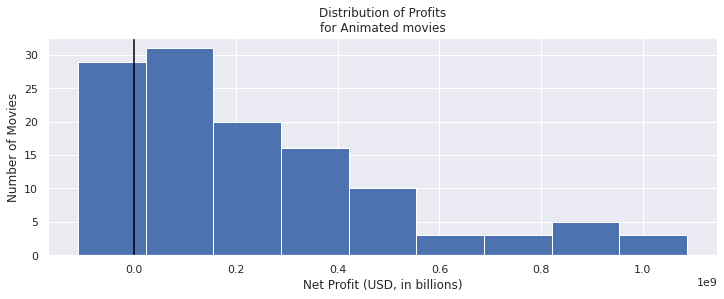

In [49]:
fig, ax = plt.subplots()

ax.hist(df_animation['profit'], bins='auto')
ax.axvline(x=0, color='black')
ax.set_xlabel('Net Profit (USD, in billions)')
ax.set_ylabel('Number of Movies')
ax.set_title('Distribution of Profits\nfor Animated movies');

In [50]:
print('{}% of animation movies are profitable.'.format(animation_profitability))

83.33% of animation movies are profitable.


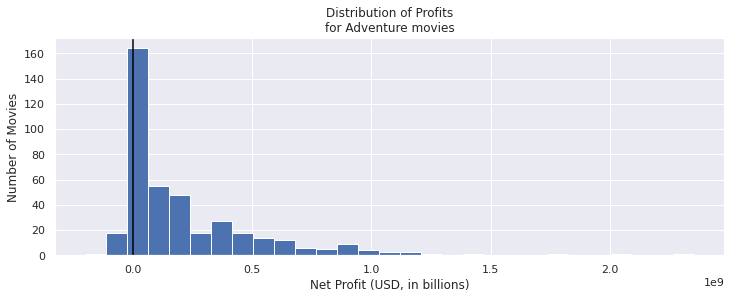

In [83]:
fig, ax = plt.subplots()

ax.hist(df_adventure['profit'], bins='auto')
ax.axvline(x=0, color='black')
ax.set_xlabel('Net Profit (USD, in billions)')
ax.set_ylabel('Number of Movies')
ax.set_title('Distribution of Profits\nfor Adventure movies');

In [52]:
print('{}% of adventure movies are profitable.'.format(adventure_profitability))

78.05% of adventure movies are profitable.


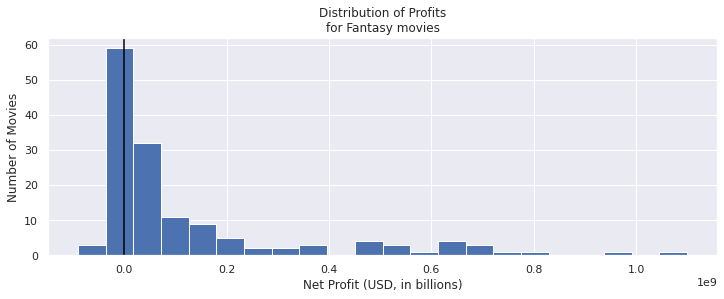

In [53]:
fig, ax = plt.subplots()

ax.hist(df_fantasy['profit'], bins='auto')
ax.axvline(x=0, color='black')
ax.set_xlabel('Net Profit (USD, in billions)')
ax.set_ylabel('Number of Movies')
ax.set_title('Distribution of Profits\nfor Fantasy movies');

In [54]:
print('{}% of fantasy movies are profitable.'.format(fantasy_profitability))

74.48% of fantasy movies are profitable.


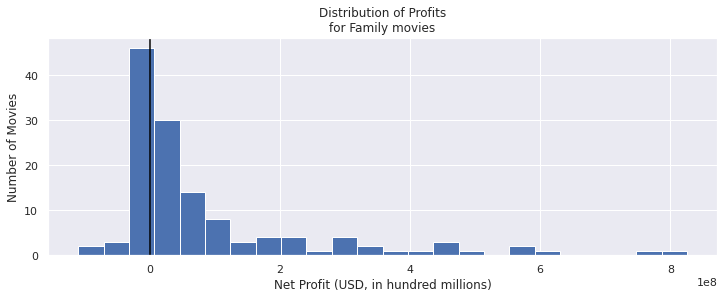

In [55]:
fig, ax = plt.subplots()

ax.hist(df_family['profit'], bins='auto')
ax.axvline(x=0, color='black')
ax.set_xlabel('Net Profit (USD, in hundred millions)')
ax.set_ylabel('Number of Movies')
ax.set_title('Distribution of Profits\nfor Family movies');

In [56]:
print('{}% of family movies are profitable.'.format(family_profitability))

71.21% of family movies are profitable.


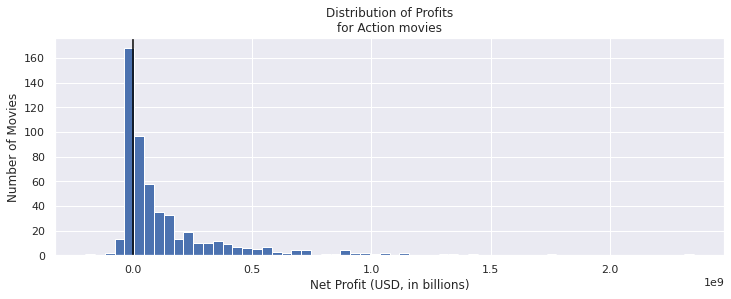

In [57]:
fig, ax = plt.subplots()

ax.hist(df_action['profit'], bins='auto')
ax.axvline(x=0, color='black')
ax.set_xlabel('Net Profit (USD, in billions)')
ax.set_ylabel('Number of Movies')
ax.set_title('Distribution of Profits\nfor Action movies');

In [58]:
print('{}% of action movies are profitable.'.format(action_profitability))

68.96% of action movies are profitable.


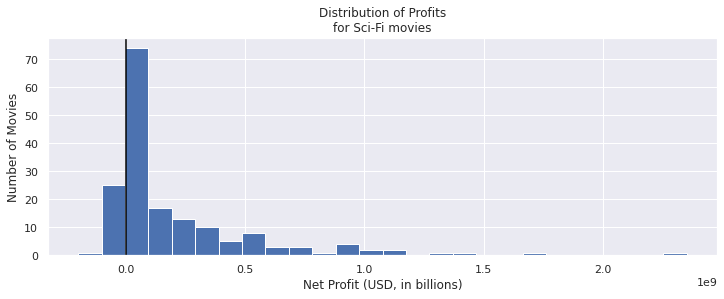

In [59]:
fig, ax = plt.subplots()

ax.hist(df_scifi['profit'], bins='auto')
ax.axvline(x=0, color='black')
ax.set_xlabel('Net Profit (USD, in billions)')
ax.set_ylabel('Number of Movies')
ax.set_title('Distribution of Profits\nfor Sci-Fi movies');

In [60]:
print('{}% of comedy movies are profitable.'.format(comedy_profitability))

68.29% of comedy movies are profitable.


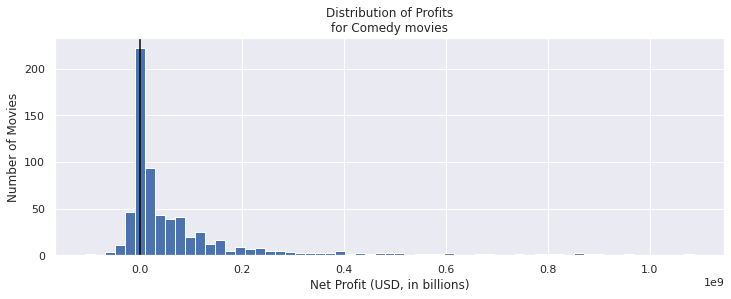

In [61]:
fig, ax = plt.subplots()

ax.hist(df_comedy['profit'], bins='auto')
ax.axvline(x=0, color='black')
ax.set_xlabel('Net Profit (USD, in billions)')
ax.set_ylabel('Number of Movies')
ax.set_title('Distribution of Profits\nfor Comedy movies');

In [62]:
print('{}% of Sci-Fi movies are profitable.'.format(scifi_profitability))

66.28% of Sci-Fi movies are profitable.


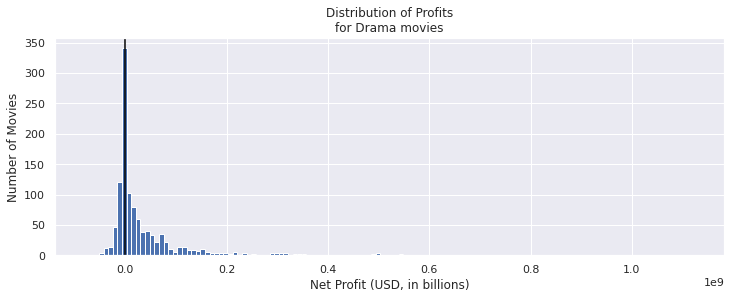

In [63]:
fig, ax = plt.subplots()

ax.hist(df_drama['profit'], bins='auto')
ax.axvline(x=0, color='black')
ax.set_xlabel('Net Profit (USD, in billions)')
ax.set_ylabel('Number of Movies')
ax.set_title('Distribution of Profits\nfor Drama movies');

In [64]:
print('{}% of drama movies are profitable.'.format(drama_profitability))

57.66% of drama movies are profitable.


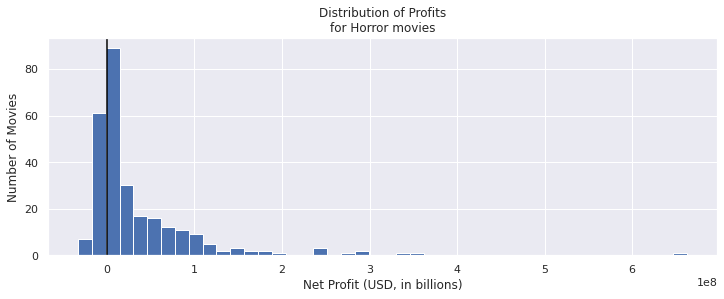

In [65]:
fig, ax = plt.subplots()

ax.hist(df_horror['profit'], bins='auto')
ax.axvline(x=0, color='black')
ax.set_xlabel('Net Profit (USD, in billions)')
ax.set_ylabel('Number of Movies')
ax.set_title('Distribution of Profits\nfor Horror movies');

In [66]:
print('{}% of horror movies are profitable.'.format(horror_profitability))

57.61% of horror movies are profitable.


In [67]:
print('The median profit of animation movies is {}.'.format(int(df_animation.median(numeric_only=True)[-3])))
print('The median profit of adventure movies is {}.'.format(int(df_adventure.median(numeric_only=True)[-3])))
print('The median profit of action movies is {}.'.format(int(df_action.median(numeric_only=True)[-3])))
print('The median profit of drama movies is {}.'.format(int(df_drama.median(numeric_only=True)[-3])))
print('The median profit of Sci-Fi movies is {}.'.format(int(df_scifi.median(numeric_only=True)[-3])))
print('The median profit of fantasy movies is {}.'.format(int(df_fantasy.median(numeric_only=True)[-3])))
print('The median profit of family movies is {}.'.format(int(df_family.median(numeric_only=True)[-3])))
print('The median profit of comedy movies is {}.'.format(int(df_comedy.median(numeric_only=True)[-3])))
print('The median profit of horror movies is {}.'.format(int(df_horror.median(numeric_only=True)[-3])))

The median profit of animation movies is 155707267.
The median profit of adventure movies is 108194745.
The median profit of action movies is 39770337.
The median profit of drama movies is 3724866.
The median profit of Sci-Fi movies is 31663530.
The median profit of fantasy movies is 27427346.
The median profit of family movies is 24244513.
The median profit of comedy movies is 17621449.
The median profit of horror movies is 5260127.


### Looking at the data another way.

It looks like certain genres (just like with budget categories) have certain high achievers in terms of consistently turning a profit. The top four seem to be animation, adventure, fantasy, and family, though with a decently smooth spread across all genres. However, the median profits seem to have much more drastic differences across genres. We'll graph both to get a better feel for the relationships.

In [68]:
profits_by_genre = [animation_profitability, adventure_profitability, fantasy_profitability, family_profitability, action_profitability, comedy_profitability, scifi_profitability, drama_profitability, horror_profitability]
genre_list = ['Animation', 'Adventure', 'Fantasy', 'Family', 'Action', 'Comedy', 'Sci-Fi', 'Drama', 'Horror']

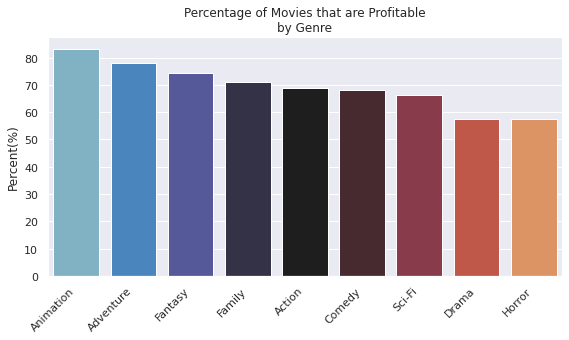

In [69]:
fig, ax = plt.subplots(figsize=(8,4))
plt.tight_layout()

sns.barplot(x=genre_list, y=profits_by_genre, palette='icefire')
ax.set_ylabel('Percent(%)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Percentage of Movies that are Profitable\nby Genre');
plt.savefig('Images/genre_profit_percentages.png', dpi=300, bbox_inches = "tight")

In [70]:
median_profits_by_genre = [df_animation.median(numeric_only=True)[-3], df_adventure.median(numeric_only=True)[-3], df_action.median(numeric_only=True)[-3], df_drama.median(numeric_only=True)[-3], df_scifi.median(numeric_only=True)[-3], df_fantasy.median(numeric_only=True)[-3], df_family.median(numeric_only=True)[-3], df_comedy.median(numeric_only=True)[-3], df_horror.median(numeric_only=True)[-3]]

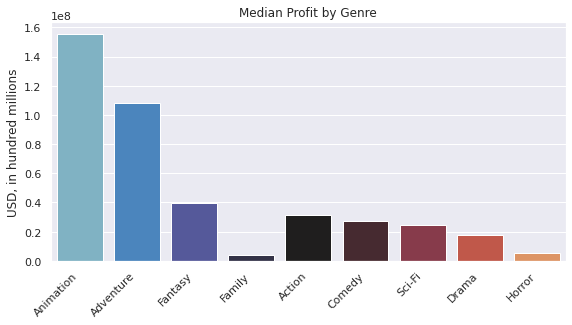

In [71]:
fig, ax = plt.subplots(figsize=(8,4))
plt.tight_layout()

sns.barplot(x=genre_list, y=median_profits_by_genre, palette='icefire')
ax.set_ylabel('USD, in hundred millions')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Median Profit by Genre')
plt.savefig('Images/genre_profit_medians.png', dpi=300, bbox_inches = "tight");

So it looks like animation and adventure are quite far ahead of all the rest of the genres in terms of mean profit, with family performing worst. That being the case, we will be recommending to Microsoft to focus their main energies on animation, adventure, and fantasy. As such, given that animation is more rightly a category than a genre, we will recommend to Microsoft to either open or acquire their own animation arm for the studio, which is a common practice amongst the major established studios.

## Next Question: Who's our audience? (i.e. Who's generating the bulk of our profits?)

To answer this question, we'll look at a few things. First, since we're mainly targeting big-budget releases, let's examine the most obvious stat first - top 25 grossing films worldwide by title.

In [72]:
df_topwwg = df_replace_na_select.nlargest(15,'worldwide_gross') # top 25 films sorted by 'worldwide_gross'
df_topwwg_select = df_topwwg[['title', 'genres', 'year', 'studio','worldwide_gross', 'domestic_gross']]
df_topwwg_select

,title,genres,year,studio,worldwide_gross,domestic_gross
0,Avatar,"Action,Adventure,Sci-Fi",2009.0,20th Century Fox,2776345279,760507625
5,Star Wars Ep. VII: The Force Awakens,"Action,Adventure,Sci-Fi",2015.0,Disney,2053311220,936662225
6,Avengers: Infinity War,"Action,Adventure,Sci-Fi",2018.0,Disney,2048134200,678815482
34,Jurassic World,"Action,Adventure,Sci-Fi",2015.0,Universal,1648854864,652270625
85,Furious 7,"Action,Crime,Thriller",2015.0,Universal,1518722794,353007020
26,The Avengers,"Action,Adventure,Sci-Fi",2012.0,Disney,1517935897,623279547
3,Avengers: Age of Ultron,"Action,Adventure,Sci-Fi",2015.0,Disney,1403013963,459005868
53,Black Panther,"Action,Adventure,Sci-Fi",2018.0,Disney,1348258224,700059566
388,Harry Potter and the Deathly Hallows: Part II,"Action,Adventure,Sci-Fi",2011.0,Warner Bros,1341693157,381193157
4,Star Wars Ep. VIII: The Last Jedi,"Action,Adventure,Sci-Fi",2017.0,Disney,1316721747,620181382


In [73]:
df_select = df_topwwg_select.copy()
df_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 0 to 22
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            15 non-null     object 
 1   genres           15 non-null     object 
 2   year             15 non-null     float64
 3   studio           15 non-null     object 
 4   worldwide_gross  15 non-null     int64  
 5   domestic_gross   15 non-null     int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 840.0+ bytes


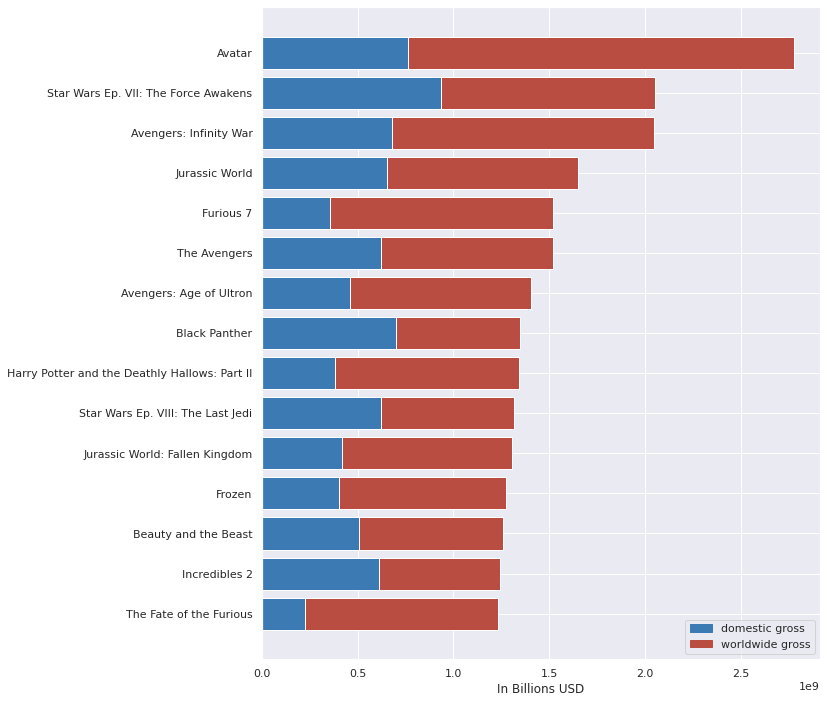

In [74]:
# Create plot
plt.rcParams.update({'font.size':15})
fig, ax = plt.subplots(figsize = (10,12))
title = df_select['title']
ww_gross = df_select['worldwide_gross']
d_gross = df_select['domestic_gross']

# ax.set_title('Top Grossing Movies - 2010 - 2018')
ax.set_xlabel('In Billions USD')

worldwide_patch = mpatches.Patch(color='#ba4d41', label='worldwide gross')
plt.legend(handles=[worldwide_patch])
domestic_patch = mpatches.Patch(color='#3c7ab4', label='domestic gross')
plt.legend(handles=[domestic_patch, worldwide_patch])

Domestic = ax.barh(title, ww_gross, color = '#ba4d41')
World = ax.barh(title, d_gross, color = '#3c7ab4')
ax.invert_yaxis()

plt.savefig('Images/top_grossing_movies.jpg', dpi=300, bbox_inches = "tight")
plt.show();

In [75]:
# Summed values for next chart
sum_ups = df_all3.groupby(['studio',]).sum('worldwide_gross').reset_index()
sum_ups = sum_ups.sort_values('worldwide_gross', ascending = False)
sum_ups = sum_ups.iloc[0:6]
sum_ups

,studio,start_year,runtime_minutes,averagerating,numvotes,year,id,domestic_gross,worldwide_gross
21,Disney,140974.0,8051.0,478.0,16107428.0,145001.0,2889,12926142171,33286017937
95,Warner Bros,269814.0,14862.0,859.1,25638763.0,277912.0,7333,12548131619,30731321168
90,Universal,231610.0,12170.0,680.7,15179649.0,231603.0,6178,10674143218,27202115309
33,Fox,213433.0,11324.0,662.0,17178497.0,219495.0,4966,9255537871,26462680578
82,Sony,138931.0,7421.0,420.7,10781367.0,146994.0,3845,6969143893,17510994901
70,Paramount,138938.0,7547.0,439.5,13530859.0,147007.0,3790,6007151536,14438105394


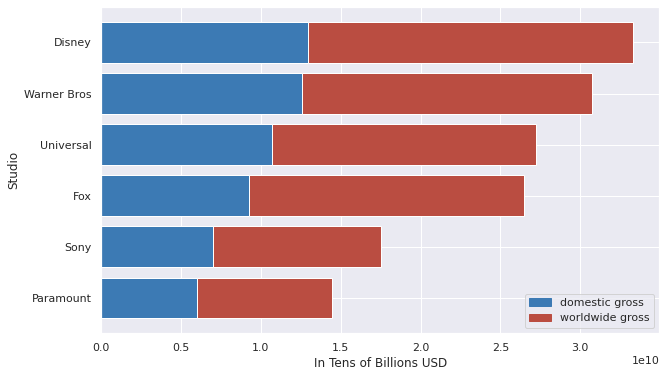

In [85]:
plt.rcParams.update({'font.size':20})
fig, ax = plt.subplots(figsize = (10,6))
studio = sum_ups['studio']
ww_gross = sum_ups['worldwide_gross']
d_gross = sum_ups['domestic_gross']

World = ax.barh(studio, ww_gross, color = '#ba4d41')
Domestic = ax.barh(studio, d_gross, color = '#3c7ab4')
ax.invert_yaxis()

# ax.set_title('Top Grossing Movie Studios - 2008 - 2018')
ax.set_xlabel('In Tens of Billions USD')
ax.set_ylabel('Studio')

worldwide_patch = mpatches.Patch(color='#ba4d41', label='worldwide gross')
plt.legend(handles=[worldwide_patch])
domestic_patch = mpatches.Patch(color='#3c7ab4', label='domestic gross')
plt.legend(handles=[domestic_patch, worldwide_patch])
          
plt.savefig('Images/top_grossing_movies_by_studio.jpg', dpi=300, bbox_inches = "tight")
plt.show();


### Making sense of it

It seems pretty clear from this data that the vast majority of profits come from the foreign markets. As such, we'll be recommending to Microsoft that in choosing scripts, stars, shooting locations, and the like, they should consider the impact or appeal to specific international markets. Sometimes this can be as simple as hiring an actor from a specific market. There are many more strategies that different film companies to achieve these ends; Microsoft should pursue those which align most with their values as a company.

## A few extra bits and bobs: Who should direct these movies and when should we release them?

Below, we'll take a look at the most profitable 100 movies in the time period, and we'll get get a list of directors for those films. Lastly, we'll see which directors appear in that list the most often. We'll consider these the "most consistently profitable" directors, since they'll have a proven track record of producing a big hit. These will be the directors we recommend to Microsoft, as opposed to say the top earners who may have only landed on the list once (e.g. James Cameron). We may need to do a small amount of manual cleaning again, just to ensure that certain data is correct after one of the more difficult joins (some popular and highly profitable films share titles with certain less popular films. When joining by title, these less popular directors end up much higher on the list as a result of being associated with the wrong movie. There doesn't seem to be a much better way around the problem.)

In [80]:
profits_recent_mov_index = profits_recent.set_index('movie')
title_akas_mov_index = title_akas_df.set_index('title')

profits_region = profits_recent_mov_index.join(title_akas_mov_index, how='left')

profits_region.sort_values('profit', ascending=False)

title_crew_tconst_index = title_crew_df.set_index('tconst')

profits_directors = profits_region.join(title_crew_tconst_index, on='title_id', how='left')

profits_directors_no_dups = profits_directors.drop_duplicates(subset='title_id')

profits_directors_no_dups.sort_values('profit', ascending=False).head(10)

,id,release_date,production_budget,domestic_gross,worldwide_gross,roi,profit,day_of_year,month,title_id,ordering,region,language,types,attributes,is_original_title,directors,writers
Avatar,1,2009-12-18,425000000,760507625,2776345279,553.257713,2351345279,352,12,tt1775309,2.0,XWW,en,imdbDisplay,NaN,0.0,nm3786927,"nm2179863,nm4392664"
Avengers: Infinity War,7,2018-04-27,300000000,678815482,2048134200,582.711400,1748134200,117,4,tt4154756,10.0,AR,NaN,imdbDisplay,NaN,0.0,"nm0751577,nm0751648","nm1321655,nm1321656,nm0498278,nm0456158,nm0800..."
Jurassic World,34,2015-06-12,215000000,652270625,1648854864,666.909239,1433854864,163,6,tt0369610,14.0,FR,NaN,imdbDisplay,NaN,0.0,nm1119880,"nm0415425,nm0798646,nm1119880,nm2081046,nm0000341"
Furious 7,67,2015-04-03,190000000,353007020,1518722794,699.327786,1328722794,93,4,tt2820852,10.0,NL,NaN,imdbDisplay,NaN,0.0,nm1490123,"nm0604555,nm0860155"
The Avengers,27,2012-05-04,225000000,623279547,1517935897,574.638176,1292935897,125,5,tt0848228,19.0,NaN,NaN,original,NaN,1.0,nm0923736,"nm0923736,nm0672015"
Black Panther,42,2018-02-16,200000000,700059566,1348258224,574.129112,1148258224,47,2,tt2905856,4.0,XWW,en,alternative,NaN,0.0,nm3865402,"nm3865402,nm3867015"
Black Panther,42,2018-02-16,200000000,700059566,1348258224,574.129112,1148258224,47,2,tt1825683,12.0,FR,NaN,imdbDisplay,NaN,0.0,nm3363032,"nm3363032,nm1963288,nm0498278,nm0456158"
Jurassic World: Fallen Kingdom,13,2018-06-22,170000000,417719760,1305772799,668.101646,1135772799,173,6,tt4881806,20.0,US,NaN,imdbDisplay,NaN,0.0,nm1291105,"nm2081046,nm1119880,nm0000341"
Frozen,56,2013-11-22,150000000,400738009,1272469910,748.313273,1122469910,326,11,tt1323045,10.0,SE,NaN,imdbDisplay,NaN,0.0,nm1697112,nm1697112
Frozen,56,2013-11-22,150000000,400738009,1272469910,748.313273,1122469910,326,11,tt2294629,11.0,FI,sv,imdbDisplay,NaN,0.0,"nm0118333,nm1601644","nm1601644,nm0026153,nm0118333,nm2280850"


In [81]:
profits_directors_no_dups = profits_directors_no_dups.dropna(subset=['directors'])

profits_directors_no_dups['single_directors'] = profits_directors_no_dups['directors'].apply(lambda x: x.split(','))

profits_directors_exploded = profits_directors_no_dups.explode('single_directors')

profits_directors_exploded = profits_directors_exploded.reset_index()
profits_directors_exploded = profits_directors_exploded.set_index('single_directors')

people_info_namecode_index = people_info_df.set_index('nconst')

profits_director_names = profits_directors_exploded.join(people_info_namecode_index, how='left')

profits_director_names.at[profits_director_names.sort_values('profit', ascending=False).index[0], 'primary_name'] = 'James Cameron'

top_consistent_directors_messy = profits_director_names.sort_values('profit', ascending=False).head(168).groupby('primary_name').count().sort_values('index', ascending=False).head(21)

top_consistent_directors_less_messy = top_consistent_directors_messy.drop(['id', 'release_date', 'production_budget', 'domestic_gross', 'worldwide_gross', 'roi', 'profit', 'day_of_year', 'title_id', 'language', 'types', 'attributes', 'is_original_title', 'directors', 'writers', 'birth_year', 'death_year', 'primary_profession', 'ordering', 'region', 'known_for_titles'], axis = 1)

top_consistent_directors_less_messy.reset_index(inplace=True)

top_consistent_directors = top_consistent_directors_less_messy.rename(columns = {'primary_name':'Name', 'index':'Number of films in Top 100'})

top_consistent_directors.set_index('Name', inplace=True)

top_consistent_directors.head(7)

,Number of films in Top 100,month
Name,,
Pierre Coffin,4,4
Christopher Nolan,3,3
Peter Jackson,3,3
Francis Lawrence,3,3
Chris Renaud,3,3
Joe Russo,3,3
Anthony Russo,3,3


### And lastly, when should we release them?

At this point, we can merely use some of our data from above to see when certain genres and budget categories typically see releases (we previously calculated the release month numerically and added it to a new columnn in our genre and budget dataframes). Although we're primarily recommending big-budget films in the adventure and fantasy genres, as well as an animated arm of the studio, we'll go ahead and look at all genres and all budget types, as this could be useful to Microsoft going forward and fleshing out our recommendations with new directins and strategies of their own.

### First we'll look at genres

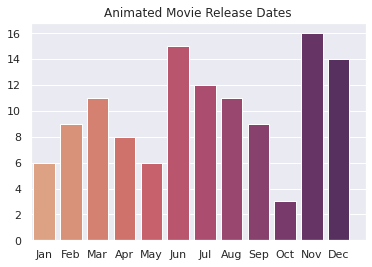

In [226]:
sns.set(rc={"figure.figsize":(6, 4)})
sns.countplot(x='month', data=df_animation, palette='flare').set(xlabel=None, ylabel=None, title ='Animated Movie Release Dates')
plt.xticks(range(13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']);
plt.savefig('Images/animated_vs_time.png');

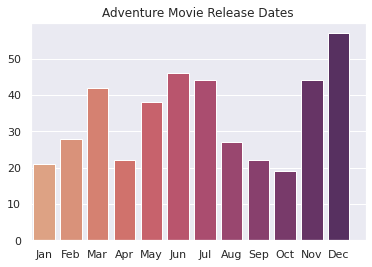

In [227]:
sns.set(rc={"figure.figsize":(6, 4)})
sns.countplot(x='month', data=df_adventure, palette='flare').set(xlabel=None, ylabel=None, title ='Adventure Movie Release Dates')
plt.xticks(range(13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']);
plt.savefig('Images/adventure_vs_time.png');

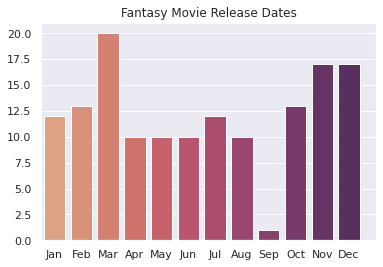

In [228]:
sns.set(rc={"figure.figsize":(6, 4)})
sns.countplot(x='month', data=df_fantasy, palette='flare').set(xlabel=None, ylabel=None, title ='Fantasy Movie Release Dates')
plt.xticks(range(13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']);
plt.savefig('Images/fantasy_vs_time.png');

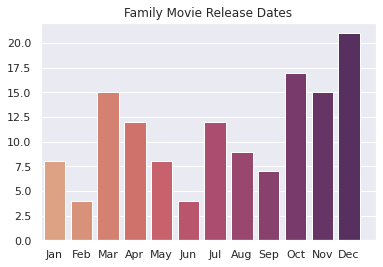

In [229]:
sns.set(rc={"figure.figsize":(6, 4)})
sns.countplot(x='month', data=df_family, palette='flare').set(xlabel=None, ylabel=None, title ='Family Movie Release Dates')
plt.xticks(range(13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']);
plt.savefig('Images/family_vs_time.png');

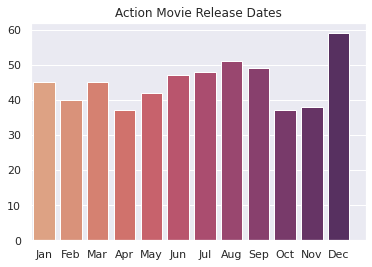

In [230]:
sns.set(rc={"figure.figsize":(6, 4)})
sns.countplot(x='month', data=df_action, palette='flare').set(xlabel=None, ylabel=None, title ='Action Movie Release Dates')
plt.xticks(range(13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']);
plt.savefig('Images/action_vs_time.png');

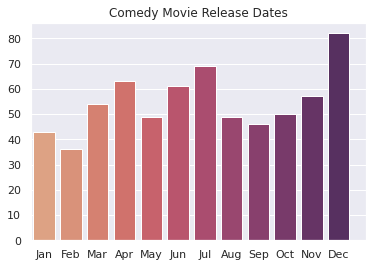

In [231]:
sns.set(rc={"figure.figsize":(6, 4)})
sns.countplot(x='month', data=df_comedy, palette='flare').set(xlabel=None, ylabel=None, title ='Comedy Movie Release Dates')
plt.xticks(range(13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']);
plt.savefig('Images/comedy_vs_time.png');

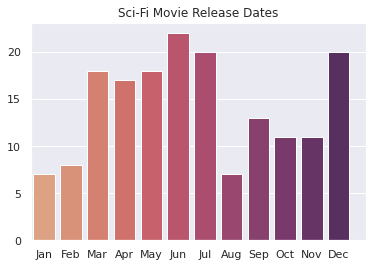

In [232]:
sns.set(rc={"figure.figsize":(6, 4)})
sns.countplot(x='month', data=df_scifi, palette='flare').set(xlabel=None, ylabel=None, title ='Sci-Fi Movie Release Dates')
plt.xticks(range(13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']);
plt.savefig('Images/scifi_vs_time.png');

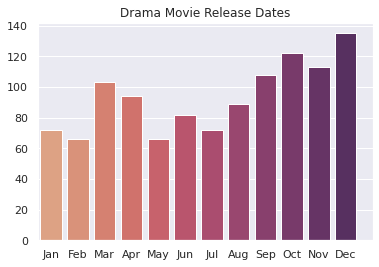

In [233]:
sns.set(rc={"figure.figsize":(6, 4)})
sns.countplot(x='month', data=df_drama, palette='flare').set(xlabel=None, ylabel=None, title ='Drama Movie Release Dates')
plt.xticks(range(13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']);
plt.savefig('Images/drama_vs_time.png');

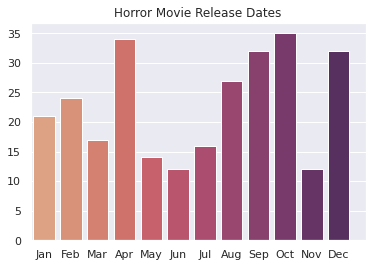

In [234]:
sns.set(rc={"figure.figsize":(6, 4)})
sns.countplot(x='month', data=df_horror, palette='flare').set(xlabel=None, ylabel=None, title ='Horror Movie Release Dates')
plt.xticks(range(13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']);
plt.savefig('Images/horror_vs_time.png');

### And now we'll look at budgets

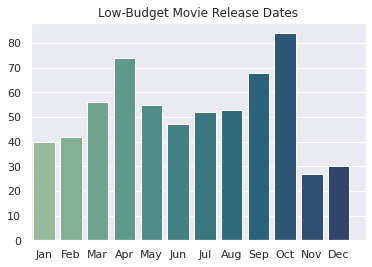

In [235]:
sns.set(rc={"figure.figsize":(6, 4)})
sns.countplot(x='month', data=low_budget, palette='crest').set(xlabel=None, ylabel=None, title ='Low-Budget Movie Release Dates')
plt.xticks(range(13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']);
plt.savefig('Images/lowbudget_vs_time.png');

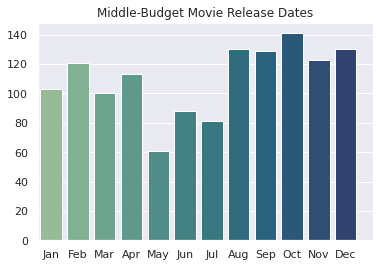

In [236]:
sns.set(rc={"figure.figsize":(6, 4)})
sns.countplot(x='month', data=middle_budget, palette='crest').set(xlabel=None, ylabel=None, title ='Middle-Budget Movie Release Dates')
plt.xticks(range(13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']);
plt.savefig('Images/middlebudget_vs_time.png');

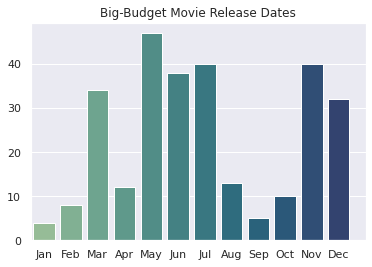

In [237]:
sns.set(rc={"figure.figsize":(6, 4)})
sns.countplot(x='month', data=big_budget, palette='crest').set(xlabel=None, ylabel=None, title ='Big-Budget Movie Release Dates')
plt.xticks(range(13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']);
plt.savefig('Images/bigbudget_vs_time.png', dpi=300, bbox_inches = "tight");

It looks like big-budget movies typically see releases in the summer and leading up to the winter holidays. This makes sense as are typically the times of year when people have free time and the inclination to see movies with friends and family; thus, it's the best time to release big-budget, wide-appeal films. 

It also looks like animated films, adventure, and fantasy all see releases during this time as well, with only fantasy not having as many releases during the summer. This also makes sense as these are some of the typical genres that are given big-budgets in the first place in order to position them to appeal to a wider audience, thereby further strenghtening our reccomendation.

## Wrapping it all up

There's a decent amount of data here that warrants a decent amount of recommendations for Microsoft's fledgeling film studio, and while we've really only been able to just scratch the surface, we do believe we have devised three solid recommendations for Microsoft going forward, which are as follows:

1. Focus the largest share of your resources and energies on big-budget tent-pole releases: not only do they tend to be more profitable, but they also tend to more consistently be profitable in the first place.

2. Open or acquire an animation arm that focuses on the same genres as the parent studio–adventure and fantasy–as these are the most consistently profitable with high median profits.

3. In choosing scripts, stars, shooting locations, and the like, consider the impact or appeal to specific international markets. They will generate the vast majority of your profits.
